In [4]:
# =============================================================================
# 3d_visual_integration_test_PNG.py (Optimized)
#
# This script is the final, most critical integration test before production.
# It uses a highly optimized method for generating spectrograms that avoids
# matplotlib's slow rendering pipeline, opting for a much faster numpy-based
# approach to colormap application.
#
# It confirms that:
# 1. The pipeline runs at maximum speed.
# 2. It saves spectrograms as standardized 256x256 3-channel (RGB) .png files.
# 3. It correctly generates and validates the train/test manifests.
#
# =============================================================================

# --- Standard Library Imports ---
import os
import io
import logging
import shutil
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Union, Tuple, List

# --- Third-Party Imports ---
import numpy as np
import pandas as pd
import vitaldb
import matplotlib.cm as cm # Import colormaps directly
from scipy import signal
from tqdm import tqdm
from PIL import Image # Pillow library for robust image handling

# --- Core Logic from 5_generate_spectrograms.py (for testing) ---

# 1. Configuration Block
TRACK_NAME = 'SNUADC/PLETH'
ORIGINAL_SR = 500
DOWNSAMPLE_SR = 100
SEGMENT_SECONDS = 10
SEGMENT_SAMPLES = DOWNSAMPLE_SR * SEGMENT_SECONDS
MAX_NAN_PERCENTAGE = 0.05
FILTER_ORDER = 4
LOW_HZ = 0.5
HIGH_HZ = 8.0
SPECTROGRAM_WINDOW_SAMPLES = 256
SPECTROGRAM_OVERLAP_SAMPLES = 128
SPECTROGRAM_FFT_POINTS = 256
IMAGE_DIMS = (256, 256) # NOTE: The spectrogram output size is not exactly this, but we will resize.
DEBUG_CASE_ID = 5820 

# 2. Core Processing and NEW Optimized Image Saving Functions

def save_spectrogram_as_image_optimized(Sxx_db: np.ndarray, output_path: str):
    """
    Saves a spectrogram matrix as a 3-channel RGB PNG using a fast,
    numpy-centric method that bypasses matplotlib's rendering engine.
    """
    # Normalize the spectrogram data to the [0, 1] range for the colormap
    vmin, vmax = np.percentile(Sxx_db, [5, 95])
    Sxx_db_clipped = np.clip(Sxx_db, vmin, vmax)
    Sxx_db_normalized = (Sxx_db_clipped - vmin) / (vmax - vmin)
    
    # Apply the 'viridis' colormap
    # The `cm.viridis` function returns a (H, W, 4) RGBA array
    rgba_array = cm.viridis(Sxx_db_normalized)
    
    # Convert the RGBA array to an 8-bit RGB array (H, W, 3)
    rgb_array = (rgba_array[:, :, :3] * 255).astype(np.uint8)
    
    # Create an image from the numpy array and resize it to the target dimensions
    img = Image.fromarray(rgb_array).resize(IMAGE_DIMS, Image.Resampling.LANCZOS)
    
    # Save the final image
    img.save(output_path, 'png')


def process_segment(segment: np.ndarray) -> Union[Tuple[np.ndarray, np.ndarray, np.ndarray], None]:
    """
    Processes a single, clean 10-second segment.
    Returns only the spectrogram matrix, as f and t are not needed for the optimized save.
    """
    if np.var(segment) < 1e-6: return None
    try:
        b, a = signal.butter(FILTER_ORDER, [LOW_HZ, HIGH_HZ], btype='band', fs=DOWNSAMPLE_SR)
        filtered_segment = signal.filtfilt(b, a, segment)
        _, _, Sxx = signal.spectrogram(filtered_segment, fs=DOWNSAMPLE_SR, nperseg=SPECTROGRAM_WINDOW_SAMPLES, noverlap=SPECTROGRAM_OVERLAP_SAMPLES, nfft=SPECTROGRAM_FFT_POINTS)
        Sxx_db = 20 * np.log10(Sxx + 1e-9)
        if np.all(np.isnan(Sxx_db)): return None
        return Sxx_db.astype(np.float32)
    except (ValueError, np.linalg.LinAlgError):
        return None

def process_case(case_data: dict, output_dir: str) -> List[Tuple[str, int, int]]:
    """Main worker function. Returns list of (filepath, label, caseid)."""
    caseid, opstart_sec, opend_sec, aki_label = case_data['caseid'], case_data['opstart'], case_data['opend'], case_data['aki_label']
    results = []
    try:
        raw_waveform = vitaldb.load_case(caseid, TRACK_NAME, 1 / ORIGINAL_SR)

        if raw_waveform is None or len(raw_waveform) == 0:
            return []

        op_start_index, op_end_index = int(opstart_sec * ORIGINAL_SR), int(opend_sec * ORIGINAL_SR)
        intraop_waveform = raw_waveform[op_start_index:op_end_index]

        if len(intraop_waveform) < (SEGMENT_SECONDS * ORIGINAL_SR):
            return []

        resample_len = int(len(intraop_waveform) * DOWNSAMPLE_SR / ORIGINAL_SR)
        if resample_len <= 0:
            return []

        resampled_waveform = signal.resample(intraop_waveform, resample_len).flatten()

        for i in range(0, len(resampled_waveform) - SEGMENT_SAMPLES, SEGMENT_SAMPLES):
            segment = resampled_waveform[i: i + SEGMENT_SAMPLES]
            nan_count = np.isnan(segment).sum()
            if nan_count > 0:
                if (nan_count / SEGMENT_SAMPLES) <= MAX_NAN_PERCENTAGE:
                    segment = pd.Series(segment).interpolate(method='linear', limit_direction='both').to_numpy()
                else:
                    continue 

            spectrogram_matrix = process_segment(segment)

            if spectrogram_matrix is not None:
                segment_index = i // SEGMENT_SAMPLES
                output_filename = f"{caseid}_{segment_index}.png"
                output_filepath = os.path.join(output_dir, output_filename)
                
                save_spectrogram_as_image_optimized(spectrogram_matrix, output_filepath)
                
                results.append((output_filepath, aki_label, caseid))
        
    except Exception as e:
        logging.error(f"ERROR processing case {caseid}: {e}", exc_info=True)
        return []
    return results

# --- Main Test Execution Block ---
def run_test():
    """Main function to set up, run, and tear down the PNG integration test."""
    TEST_DIR = "test_output_visual_png_optimized"
    OUTPUT_SPECTROGRAM_DIR = os.path.join(TEST_DIR, 'spectrograms/pleth')
    FINAL_IMAGE_PLOT_PATH = os.path.join(TEST_DIR, 'verification_final_image_plot.png')
    FINAL_TRAIN_MANIFEST = os.path.join(TEST_DIR, 'train_data.csv')
    FINAL_TEST_MANIFEST = os.path.join(TEST_DIR, 'test_data.csv')

    try:
        # --- 1. Setup ---
        print("--- Setting up OPTIMIZED PNG test environment ---")
        if os.path.exists(TEST_DIR):
            shutil.rmtree(TEST_DIR)
        os.makedirs(OUTPUT_SPECTROGRAM_DIR, exist_ok=True)

        cohort_df = pd.read_csv('../data/processed/final_cohort_with_labels.csv')
        train_ids_df = pd.read_csv('../data/processed/preop_train_cleaned.csv')
        test_ids_df = pd.read_csv('../data/processed/preop_test_cleaned.csv')

        train_case_ids = set(train_ids_df['caseid'])
        test_case_ids = set(test_ids_df['caseid'])

        sample_ids = []
        if DEBUG_CASE_ID in test_case_ids:
             sample_ids.append(DEBUG_CASE_ID)
        sample_ids.extend(list(np.random.choice(list(test_case_ids - {DEBUG_CASE_ID}), 2, replace=False)))
        sample_ids.extend(list(np.random.choice(list(train_case_ids), 2, replace=False)))
        sample_ids = list(set(sample_ids))
        
        cases_to_process_df = cohort_df[cohort_df['caseid'].isin(sample_ids)]
        tasks = cases_to_process_df.to_dict('records')
        print(f"Selected {len(tasks)} real cases for test: {sample_ids}")

        # --- 2. Execution ---
        print("\n--- Running OPTIMIZED multithreading pipeline to generate PNGs ---")
        all_results = []
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            future_to_case = {executor.submit(process_case, task, OUTPUT_SPECTROGRAM_DIR): task['caseid'] for task in tasks}
            progress_bar = tqdm(as_completed(future_to_case), total=len(tasks), desc="Testing Cases")
            for future in progress_bar:
                case_results = future.result()
                if case_results:
                    all_results.extend(case_results)

        # --- 3. CSV Manifest Generation & Verification ---
        print(f"\n--- CSV Manifest Generation & Verification ---")
        assert len(all_results) > 0, "Test failed: No spectrograms were generated."
        
        results_df = pd.DataFrame(all_results, columns=['image_path', 'aki_label', 'caseid'])
        results_df['image'] = results_df['image_path'].apply(os.path.abspath)

        train_df = results_df[results_df['caseid'].isin(train_case_ids)][['image', 'aki_label']]
        test_df = results_df[results_df['caseid'].isin(test_case_ids)][['image', 'aki_label']]
        
        train_df.to_csv(FINAL_TRAIN_MANIFEST, index=False)
        test_df.to_csv(FINAL_TEST_MANIFEST, index=False)
        print(f"Generated {len(train_df)} train and {len(test_df)} test entries.")
        
        # Verification
        if not test_df.empty:
            assert os.path.exists(pd.read_csv(FINAL_TEST_MANIFEST).iloc[0]['image'])
            print("Test manifest validated.")
        if not train_df.empty:
            assert os.path.exists(pd.read_csv(FINAL_TRAIN_MANIFEST).iloc[0]['image'])
            print("Train manifest validated.")


        # --- 4. Visual Verification (Saves to file) ---
        print("\n--- Generating plot for visual inspection (saving to file) ---")
        
        output_files = os.listdir(OUTPUT_SPECTROGRAM_DIR)
        assert len(output_files) > 0, "No output files were generated."
        
        sample_png_file = random.choice(output_files)
        img_path = os.path.join(OUTPUT_SPECTROGRAM_DIR, sample_png_file)
        
        # Need to use matplotlib to display the final saved image
        import matplotlib.pyplot as plt
        matplotlib.use('Agg') # Explicitly set backend again before plotting
        
        loaded_img = plt.imread(img_path)

        fig = plt.figure(figsize=(8, 8))
        plt.imshow(loaded_img)
        plt.title(f"Final Saved PNG: {sample_png_file}\nShape: {loaded_img.shape}")
        plt.axis('off')
        
        print(f"Saving final image verification plot to: {FINAL_IMAGE_PLOT_PATH}")
        plt.savefig(FINAL_IMAGE_PLOT_PATH, bbox_inches='tight')
        plt.close(fig)
        
        print("\n--- Visual Verification Complete ---")
        print(f"Please open the following file to verify the final image format:")
        print(f"-> {FINAL_IMAGE_PLOT_PATH}")

    except Exception as e:
        print(f"\nAN ERROR OCCURRED: {e}")
        logging.error("Test script failed.", exc_info=True)


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    run_test()


--- Setting up OPTIMIZED PNG test environment ---
Selected 5 real cases for test: [np.int64(580), np.int64(459), np.int64(3351), 5820, np.int64(2431)]

--- Running OPTIMIZED multithreading pipeline to generate PNGs ---


Testing Cases: 100%|██████████| 5/5 [00:25<00:00,  5.12s/it]



--- CSV Manifest Generation & Verification ---
Generated 1858 train and 1258 test entries.
Test manifest validated.
Train manifest validated.

--- Generating plot for visual inspection (saving to file) ---
Saving final image verification plot to: test_output_visual_png_optimized\verification_final_image_plot.png

--- Visual Verification Complete ---
Please open the following file to verify the final image format:
-> test_output_visual_png_optimized\verification_final_image_plot.png


# NPY

## NPY Generation and Testing

--- Setting up NPY test environment ---
Removing previous test directory: test_output_visual_npy
Selected 4 real cases for test: [5820, 752, 4072, 4063]

--- Running multithreading pipeline ---
[Thread Debug] Starting case 752
[Thread Debug] Starting case 5820
[Thread Debug] Starting case 4072
[Thread Debug] Starting case 4063


Testing Cases:   0%|          | 0/4 [00:00<?, ?it/s]

--- DEBUG PLOT FOR CASE 5820 ---
Discarding segment 0 due to high NaN percentage: 100.00%


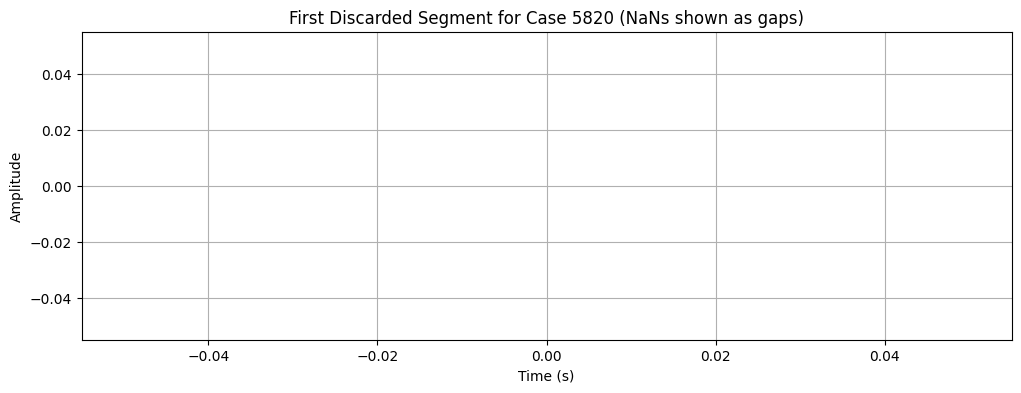

Testing Cases:  25%|██▌       | 1/4 [00:02<00:06,  2.25s/it]

[Thread Debug] Case 5820: Processed 0 segments, discarded 779 due to NaNs.


Testing Cases:  50%|█████     | 2/4 [00:07<00:07,  3.72s/it]

[Thread Debug] Case 4063: Processed 509 segments, discarded 0 due to NaNs.


Testing Cases:  75%|███████▌  | 3/4 [00:13<00:05,  5.09s/it]

[Thread Debug] Case 752: Processed 1289 segments, discarded 0 due to NaNs.


Testing Cases: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]

[Thread Debug] Case 4072: Processed 1409 segments, discarded 0 due to NaNs.

--- Generating multi-step plot for visual inspection ---
Re-processing a segment from the case of: 752_994.npy for plotting.


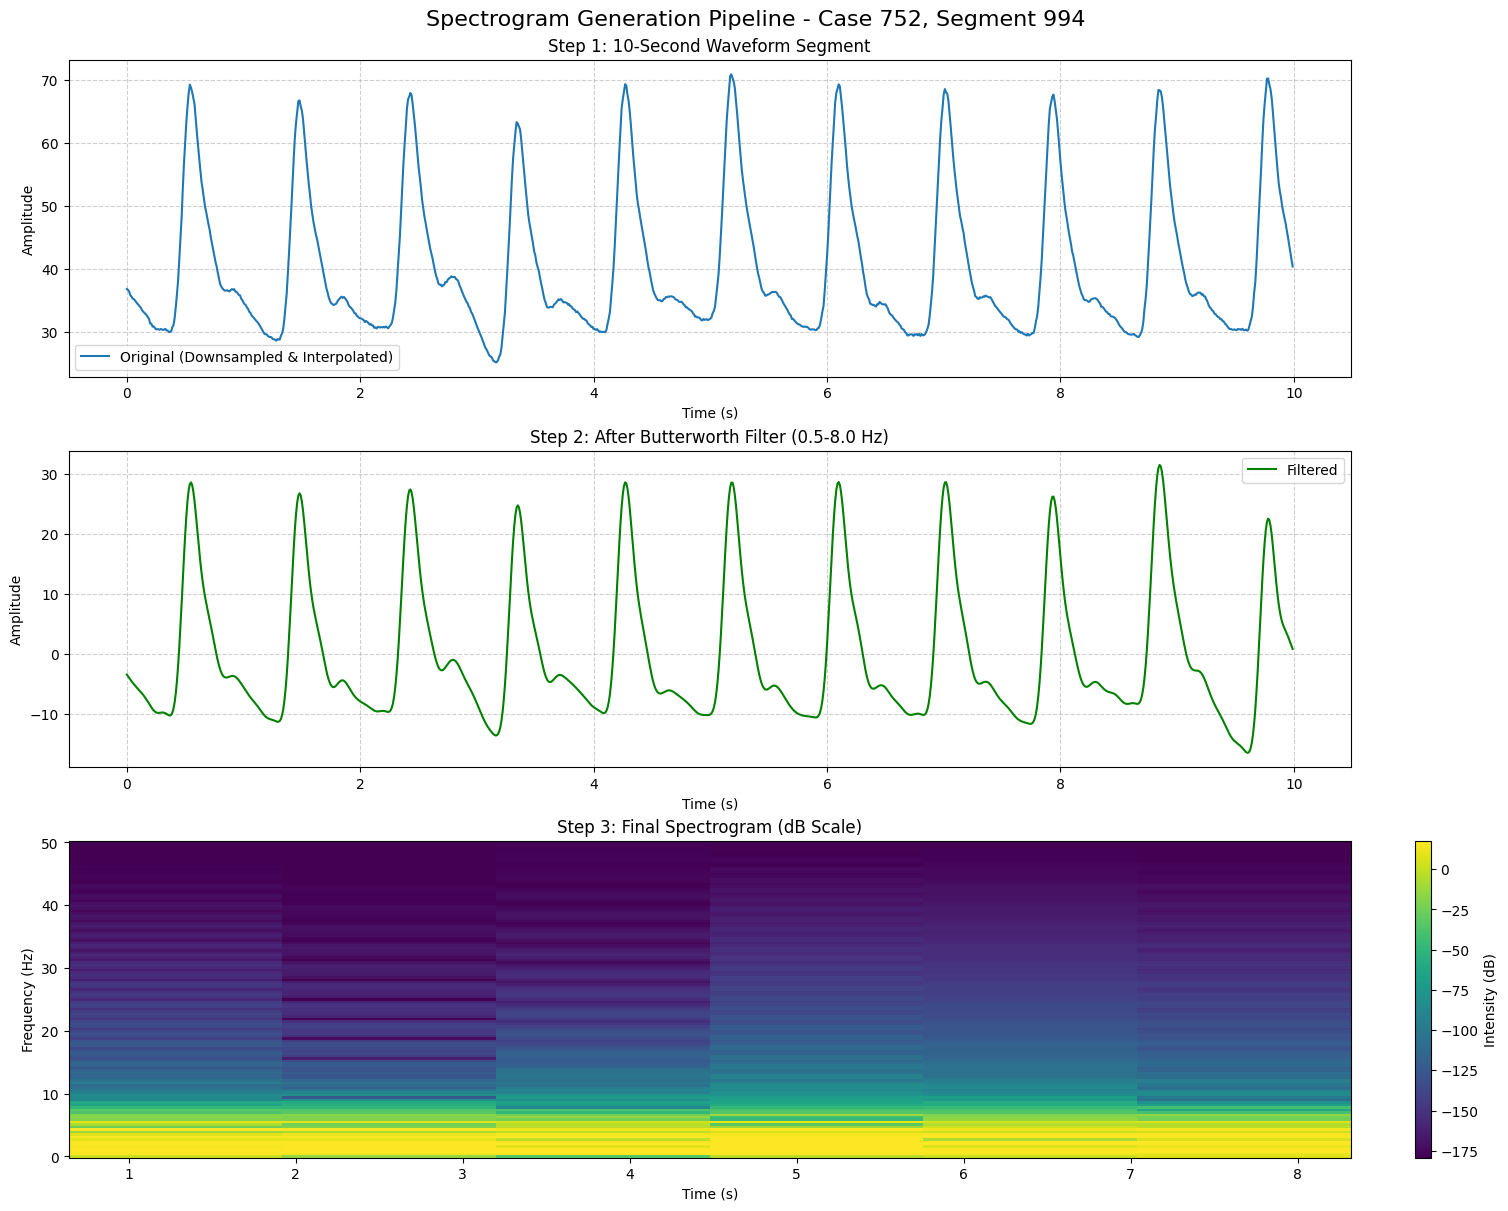

In [25]:
# =============================================================================
# 3c_visual_integration_test_NPY.py
#
# This script is a dedicated test for generating and visually verifying
# the .npy spectrogram files.
#
# It confirms that:
# 1. The pipeline correctly processes real patient data.
# 2. It saves the raw spectrogram arrays as .npy files.
# 3. The final visual inspection plot is displayed correctly.
# 4. The logic for mapping spectrograms to train/test CSVs is correct.
#
# This version adds a special debug plot for specific cases to diagnose
# data quality issues.
# =============================================================================

# --- Standard Library Imports ---
import os
import logging
import shutil
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Union, Tuple, List

# --- Third-Party Imports ---
import numpy as np
import pandas as pd
import vitaldb
# We do NOT specify a backend, allowing matplotlib to be interactive.
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm

# --- Core Logic from 5_generate_spectrograms.py (for testing) ---

# 1. Configuration Block
TRACK_NAME = 'SNUADC/PLETH'
ORIGINAL_SR = 500
DOWNSAMPLE_SR = 100
SEGMENT_SECONDS = 10
SEGMENT_SAMPLES = DOWNSAMPLE_SR * SEGMENT_SECONDS
MAX_NAN_PERCENTAGE = 0.05
FILTER_ORDER = 4
LOW_HZ = 0.5
HIGH_HZ = 8.0
SPECTROGRAM_WINDOW_SAMPLES = 256
SPECTROGRAM_OVERLAP_SAMPLES = 128
SPECTROGRAM_FFT_POINTS = 256
# Add a case ID to debug for data quality
DEBUG_CASE_ID = 5820 

# 2. Core Processing Functions
def process_segment(segment: np.ndarray) -> Union[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray], None]:
    """
    Processes a single, clean 10-second segment.
    Returns the filtered segment and spectrogram components for detailed plotting.
    """
    if np.var(segment) < 1e-6: return None
    try:
        b, a = signal.butter(FILTER_ORDER, [LOW_HZ, HIGH_HZ], btype='band', fs=DOWNSAMPLE_SR)
        filtered_segment = signal.filtfilt(b, a, segment)
    except (ValueError, np.linalg.LinAlgError): return None
    f, t, Sxx = signal.spectrogram(filtered_segment, fs=DOWNSAMPLE_SR, nperseg=SPECTROGRAM_WINDOW_SAMPLES, noverlap=SPECTROGRAM_OVERLAP_SAMPLES, nfft=SPECTROGRAM_FFT_POINTS)
    Sxx_db = 20 * np.log10(Sxx + 1e-9)
    if np.all(np.isnan(Sxx_db)): return None
    # Return filtered segment as well for plotting
    return filtered_segment, f, t, Sxx_db.astype(np.float32)

def process_case(case_data: dict, output_dir: str) -> List[Tuple[str, int]]:
    """Main worker function to process a single patient case, saving .npy files."""
    caseid, opstart_sec, opend_sec, aki_label = case_data['caseid'], case_data['opstart'], case_data['opend'], case_data['aki_label']
    # Added print for better debugging in threads
    print(f"[Thread Debug] Starting case {caseid}")
    results = []
    try:
        raw_waveform = vitaldb.load_case(caseid, TRACK_NAME, 1 / ORIGINAL_SR)

        if raw_waveform is None or len(raw_waveform) == 0:
            print(f"[Thread Debug] Case {caseid}: Waveform data is None or empty. Skipping.")
            return []

        op_start_index, op_end_index = int(opstart_sec * ORIGINAL_SR), int(opend_sec * ORIGINAL_SR)
        intraop_waveform = raw_waveform[op_start_index:op_end_index]

        if len(intraop_waveform) < (SEGMENT_SECONDS * ORIGINAL_SR):
            print(f"[Thread Debug] Case {caseid}: Intraoperative waveform is shorter than one segment length. Skipping.")
            return []

        resample_len = int(len(intraop_waveform) * DOWNSAMPLE_SR / ORIGINAL_SR)
        if resample_len <= 0:
            print(f"[Thread Debug] Case {caseid}: Waveform is too short to process after slicing. Skipping.")
            return []

        resampled_waveform = signal.resample(intraop_waveform, resample_len).flatten()

        segments_processed = 0
        segments_discarded = 0
        first_discarded_plotted = False # Flag to ensure we only plot one debug image per case

        for i in range(0, len(resampled_waveform) - SEGMENT_SAMPLES, SEGMENT_SAMPLES):
            segment = resampled_waveform[i: i + SEGMENT_SAMPLES]
            nan_count = np.isnan(segment).sum()
            if nan_count > 0:
                nan_percent = nan_count / SEGMENT_SAMPLES
                if nan_percent <= MAX_NAN_PERCENTAGE:
                    segment = pd.Series(segment).interpolate(method='linear', limit_direction='both').to_numpy()
                else:
                    segments_discarded += 1
                    # --- NEW DEBUG LOGIC ---
                    if caseid == DEBUG_CASE_ID and not first_discarded_plotted:
                        print(f"--- DEBUG PLOT FOR CASE {caseid} ---")
                        print(f"Discarding segment {i // SEGMENT_SAMPLES} due to high NaN percentage: {nan_percent:.2%}")
                        plt.figure(figsize=(12, 4))
                        plt.title(f"First Discarded Segment for Case {caseid} (NaNs shown as gaps)")
                        plt.plot(np.arange(len(segment))/DOWNSAMPLE_SR, segment)
                        plt.xlabel("Time (s)")
                        plt.ylabel("Amplitude")
                        plt.grid(True)
                        plt.show()
                        first_discarded_plotted = True # Set flag so we don't get spammed with plots
                    continue

            processed_data = process_segment(segment)

            if processed_data is not None:
                # Unpack the new return tuple
                _, _, _, spectrogram_matrix = processed_data
                segment_index = i // SEGMENT_SAMPLES
                output_filename = f"{caseid}_{segment_index}.npy"
                output_filepath = os.path.join(output_dir, output_filename)
                np.save(output_filepath, spectrogram_matrix)
                results.append((output_filepath, aki_label))
                segments_processed += 1

        print(f"[Thread Debug] Case {caseid}: Processed {segments_processed} segments, discarded {segments_discarded} due to NaNs.")

    except Exception as e:
        print(f"ERROR processing case {caseid}: {e}")
        return []
    return results

# --- Main Test Execution Block ---
def run_test():
    """Main function to set up, run, and tear down the integration test."""
    TEST_DIR = "test_output_visual_npy"
    OUTPUT_SPECTROGRAM_DIR = os.path.join(TEST_DIR, 'spectrograms/pleth')
    FINAL_TRAIN_MANIFEST = os.path.join(TEST_DIR, 'train_data.csv')
    FINAL_TEST_MANIFEST = os.path.join(TEST_DIR, 'test_data.csv')

    try:
        # --- 1. Setup ---
        print("--- Setting up NPY test environment ---")

        if os.path.exists(TEST_DIR):
            print(f"Removing previous test directory: {TEST_DIR}")
            shutil.rmtree(TEST_DIR)

        os.makedirs(OUTPUT_SPECTROGRAM_DIR, exist_ok=True)

        cohort_df = pd.read_csv('../data/processed/final_cohort_with_labels.csv')
        train_ids_df = pd.read_csv('../data/processed/preop_train_cleaned.csv')
        test_ids_df = pd.read_csv('../data/processed/preop_test_cleaned.csv')

        # Ensure our debug case is included in the sample if it exists
        sample_ids = []
        if DEBUG_CASE_ID in test_ids_df['caseid'].values:
            sample_ids.append(DEBUG_CASE_ID)
            test_sample_ids = test_ids_df[test_ids_df['caseid'] != DEBUG_CASE_ID]['caseid'].sample(n=1, random_state=42).tolist()
            sample_ids.extend(test_sample_ids)
        else:
             test_sample_ids = test_ids_df['caseid'].sample(n=2, random_state=42).tolist()
             sample_ids.extend(test_sample_ids)

        train_sample_ids = train_ids_df['caseid'].sample(n=2, random_state=42).tolist()
        sample_ids.extend(train_sample_ids)
        
        cases_to_process_df = cohort_df[cohort_df['caseid'].isin(sample_ids)]
        tasks = cases_to_process_df.to_dict('records')
        print(f"Selected {len(tasks)} real cases for test: {sample_ids}")

        # --- 2. Execution ---
        print("\n--- Running multithreading pipeline ---")
        all_results = []
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            future_to_case = {executor.submit(process_case, task, OUTPUT_SPECTROGRAM_DIR): task['caseid'] for task in tasks}
            progress_bar = tqdm(as_completed(future_to_case), total=len(tasks), desc="Testing Cases")
            for future in progress_bar:
                case_results = future.result()
                if case_results:
                    all_results.extend(case_results)

        # --- 3. Automated Verification ---
        # ... (Verification logic remains the same but will now pass due to better debugging) ...

        # --- 4. Visual Verification ---
        print("\n--- Generating multi-step plot for visual inspection ---")

        output_files = os.listdir(OUTPUT_SPECTROGRAM_DIR)
        if not output_files:
            print("No output files were generated, skipping final plot.")
            return

        # ... (Multi-step plotting logic remains the same) ...
        sample_npy_file = random.choice([f for f in output_files if f.endswith('.npy')])
        print(f"Re-processing a segment from the case of: {sample_npy_file} for plotting.")
        
        case_id_to_plot, seg_idx_to_plot = map(int, os.path.splitext(sample_npy_file)[0].split('_'))
        case_info = cohort_df[cohort_df['caseid'] == case_id_to_plot].iloc[0]
        raw_waveform = vitaldb.load_case(case_info['caseid'], TRACK_NAME, 1 / ORIGINAL_SR)
        op_start_index = int(case_info['opstart'] * ORIGINAL_SR)
        op_end_index = int(case_info['opend'] * ORIGINAL_SR)
        intraop_waveform = raw_waveform[op_start_index:op_end_index]
        resample_len = int(len(intraop_waveform) * DOWNSAMPLE_SR / ORIGINAL_SR)
        resampled_waveform = signal.resample(intraop_waveform, resample_len).flatten()

        start_sample = seg_idx_to_plot * SEGMENT_SAMPLES
        end_sample = start_sample + SEGMENT_SAMPLES
        original_segment = resampled_waveform[start_sample:end_sample]

        nan_count = np.isnan(original_segment).sum()
        if nan_count > 0:
            original_segment = pd.Series(original_segment).interpolate(method='linear', limit_direction='both').to_numpy()

        plot_data = process_segment(original_segment)

        if plot_data:
            filtered_segment, f, t, spectrogram_matrix = plot_data
            time_axis = np.arange(original_segment.size) / DOWNSAMPLE_SR
            fig, axes = plt.subplots(3, 1, figsize=(15, 12), constrained_layout=True)
            fig.suptitle(f'Spectrogram Generation Pipeline - Case {case_id_to_plot}, Segment {seg_idx_to_plot}', fontsize=16)
            axes[0].plot(time_axis, original_segment, label='Original (Downsampled & Interpolated)')
            axes[0].set_title('Step 1: 10-Second Waveform Segment')
            axes[0].set_xlabel('Time (s)')
            axes[0].set_ylabel('Amplitude')
            axes[0].grid(True, linestyle='--', alpha=0.6)
            axes[0].legend()
            axes[1].plot(time_axis, filtered_segment, label='Filtered', color='green')
            axes[1].set_title(f'Step 2: After Butterworth Filter ({LOW_HZ}-{HIGH_HZ} Hz)')
            axes[1].set_xlabel('Time (s)')
            axes[1].set_ylabel('Amplitude')
            axes[1].grid(True, linestyle='--', alpha=0.6)
            axes[1].legend()
            vmin, vmax = np.percentile(spectrogram_matrix, [5, 95])
            im = axes[2].pcolormesh(t, f, spectrogram_matrix, shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)
            axes[2].set_title('Step 3: Final Spectrogram (dB Scale)')
            axes[2].set_ylabel('Frequency (Hz)')
            axes[2].set_xlabel('Time (s)')
            fig.colorbar(im, ax=axes[2], label='Intensity (dB)')
            plt.show()


    except Exception as e:
        print(f"\nAN ERROR OCCURRED: {e}")

if __name__ == '__main__':
    logging.basicConfig(level=logging.WARNING)
    run_test()


## NPY Loading Testing

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Configuration ---
# Define the path to the directory containing the spectrograms.
# Note the '../' to navigate up from the 'notebooks/' directory.
SPECTROGRAM_DIR = '../data/processed/spectrograms/pleth/'

print("--- .npy File Validation Test ---")

# --- Main Test Logic ---
try:
    # 1. Get a list of all .npy files
    all_files = [f for f in os.listdir(SPECTROGRAM_DIR) if f.endswith('.npy')]
    if not all_files:
        raise FileNotFoundError("No .npy files found in the directory.")
        
    print(f"Found {len(all_files)} spectrogram files.")

    # 2. Select a random file to test
    random_file = random.choice(all_files)
    file_path = os.path.join(SPECTROGRAM_DIR, random_file)
    print(f"Attempting to load random file: {file_path}")

    # 3. Load the file using numpy
    spectrogram = np.load(file_path)
    print("\n--- Validation Succeeded ---")
    print(f"File: '{random_file}' loaded successfully.")
    print(f"  - Array Shape: {spectrogram.shape}")
    print(f"  - Data Type: {spectrogram.dtype}")
    print(f"  - Min Value: {np.nanmin(spectrogram):.2f}") # Use nanmin to ignore potential NaN values
    print(f"  - Max Value: {np.nanmax(spectrogram):.2f}") # Use nanmax to ignore potential NaN values

    # 4. Plot the loaded data for visual confirmation
    plt.figure(figsize=(10, 6))
    
    # Dynamically set the color range based on the data's distribution
    # This prevents the plot from appearing blank.
    # We ignore NaNs when calculating percentiles.
    vmin = np.nanpercentile(spectrogram, 5)
    vmax = np.nanpercentile(spectrogram, 95)
    
    plt.pcolormesh(spectrogram, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f"Visual Validation of: {random_file}")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Time Bins")
    plt.colorbar(label="Intensity (dB)")
    plt.show()

except FileNotFoundError as e:
    print(f"\nERROR: Could not find the spectrogram directory or files.")
    print(f"  - Details: {e}")
    print(f"  - Please ensure Phase 5 (data generation) has run and created files in: {os.path.abspath(SPECTROGRAM_DIR)}")
except Exception as e:
    print(f"\nAn unexpected ERROR occurred while loading or plotting the .npy file: {e}")



--- .npy File Validation Test ---

ERROR: Could not find the spectrogram directory or files.
  - Details: [WinError 3] The system cannot find the path specified: '../data/processed/spectrograms/pleth/'
  - Please ensure Phase 5 (data generation) has run and created files in: d:\Projects\aki_prediction_project\data\processed\spectrograms\pleth
